In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import defaultdict
import collections
import csv
import bottleneck
import haversine as hs
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Opening the NETCDF file

In [2]:
def wind_eval(orig_height, target_height, ds, surface_roughness):
    """Takes in an xarray dataset and evaluates the wind speed magnitude at a certain height using formula, 
    then creates a new variables and assigns it to the database and replaces the original wind speed magnitude.
    Note: Sets values of wind magnitude > 25m/s to zero."""
    #creating magnitude
    ds = ds.assign(wind_mag=lambda ds: np.sqrt(ds.u100**2 + ds.v100**2))
    
    #function to adjust for height of wind turbine
    def multiply(x,surface_roughness=surface_roughness,orig_height=orig_height,target_height=target_height):
        alpha = 0.5*(surface_roughness/10)**0.2
        factor = (target_height/orig_height)**alpha
        return x*factor
        
    ds['wind_mag'] = xr.apply_ufunc(multiply, ds['wind_mag'],input_core_dims=[["longitude","latitude"]],
               output_core_dims=[["longitude", "latitude"]], dask = 'allowed', vectorize = True)
    #dropping values above 25ms-1 (cut-out speed)
    ds['wind_mag'] = ds['wind_mag'].where((ds['wind_mag']<=25) & (ds['wind_mag']>0),0, drop=False)
    ds.wind_mag.attrs["units"] = "m s**-1"
    return ds

In [4]:
#opens and edits data


original_height = 100 #metres
height = 112 #metres
surface_roughness = 0.0005

#opens and concatenates all UK datasets
paths = ['./data/netcdf/100m1998-03.nc','./data/netcdf/100m2004-09.nc','./data/netcdf/100m2010-15.nc','./data/netcdf/100m2016-21.nc']
#european locations incl.
# paths = ['./data/euro_locs/france_98-03.nc','./data/euro_locs/france_04-09.nc','./data/euro_locs/france_10-15.nc','./data/euro_locs/france_16-21.nc','./data/euro_locs/italy_98-03.nc','./data/euro_locs/italy_04-09.nc','./data/euro_locs/italy_10-15.nc','./data/euro_locs/italy_16-21.nc','./data/euro_locs/spain_98-03.nc','./data/euro_locs/spain_04-09.nc','./data/euro_locs/spain_10-15.nc','./data/euro_locs/spain_16-21.nc','./data/netcdf/100m1998-03.nc','./data/netcdf/100m2004-09.nc','./data/netcdf/100m2010-15.nc','./data/netcdf/100m2016-21.nc']
#only european locations
# paths_france = ['./data/euro_locs/france_98-03.nc','./data/euro_locs/france_04-09.nc','./data/euro_locs/france_10-15.nc','./data/euro_locs/france_16-21.nc']
# paths_italy = ['./data/euro_locs/italy_98-03.nc','./data/euro_locs/italy_04-09.nc','./data/euro_locs/italy_10-15.nc','./data/euro_locs/italy_16-21.nc']
# paths_spain = ['./data/euro_locs/spain_98-03.nc','./data/euro_locs/spain_04-09.nc','./data/euro_locs/spain_10-15.nc','./data/euro_locs/spain_16-21.nc']


ds = xr.open_mfdataset(paths, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': 200} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
# ds_france = xr.open_mfdataset(paths_france,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
# ds_italy = xr.open_mfdataset(paths_italy,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
# ds_spain = xr.open_mfdataset(paths_spain,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
# ds = xr.merge([ds_france,ds_italy,ds_spain])
ds = wind_eval(original_height,height,ds,surface_roughness)

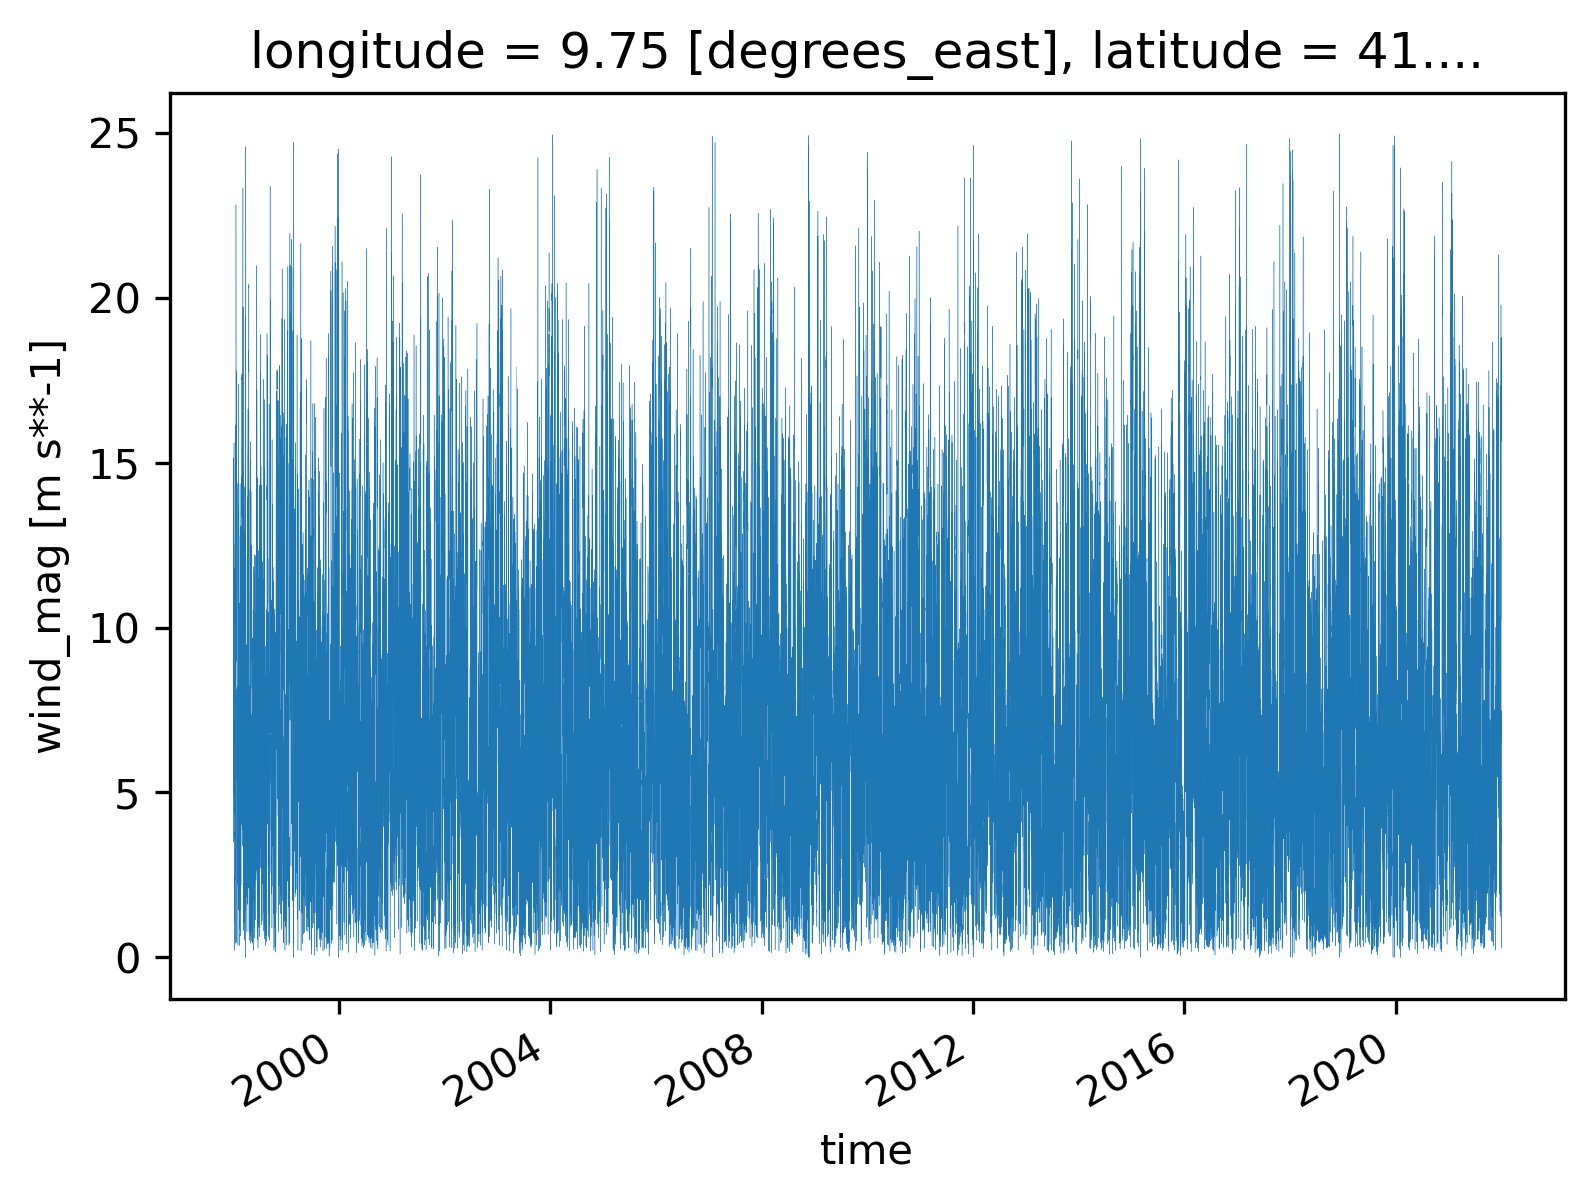

In [52]:
longitude = 9.75
latitude = 41.25

#longitude = 3
#latitude = 50

#plotting
plt.figure(dpi=300)
ds.sel(latitude=[latitude], longitude=[longitude])['wind_mag'].plot(linewidth=0.1)

## Identifying Values of separation

Going to create 4 different analytical values to fit the curve better.

In [5]:
power_curve = np.loadtxt('./data/2016CACost_NREL_Reference_8MW_180.csv',delimiter=",", dtype=str)[1:,:].astype('float')

v_min = 3
v_split = 9.5
v_rated = 12
i = 14

fit_low = np.polyfit(power_curve[2:i,0],power_curve[2:i,1]/1000,deg=3,rcond=1e-14)
fit_high = np.polyfit(power_curve[i:19,0],power_curve[i:19,1]/1000,deg=3,rcond=1e-14)

fit_low_text = np.round(fit_low,decimals=3)
fit_high_text = np.round(fit_high,decimals=3)
print(fit_low_text)
print(fit_high_text)

[ 0.008 -0.018  0.171 -0.549]
[ 1.54000e-01 -5.42200e+00  6.35600e+01 -2.40947e+02]


## Plotting Values

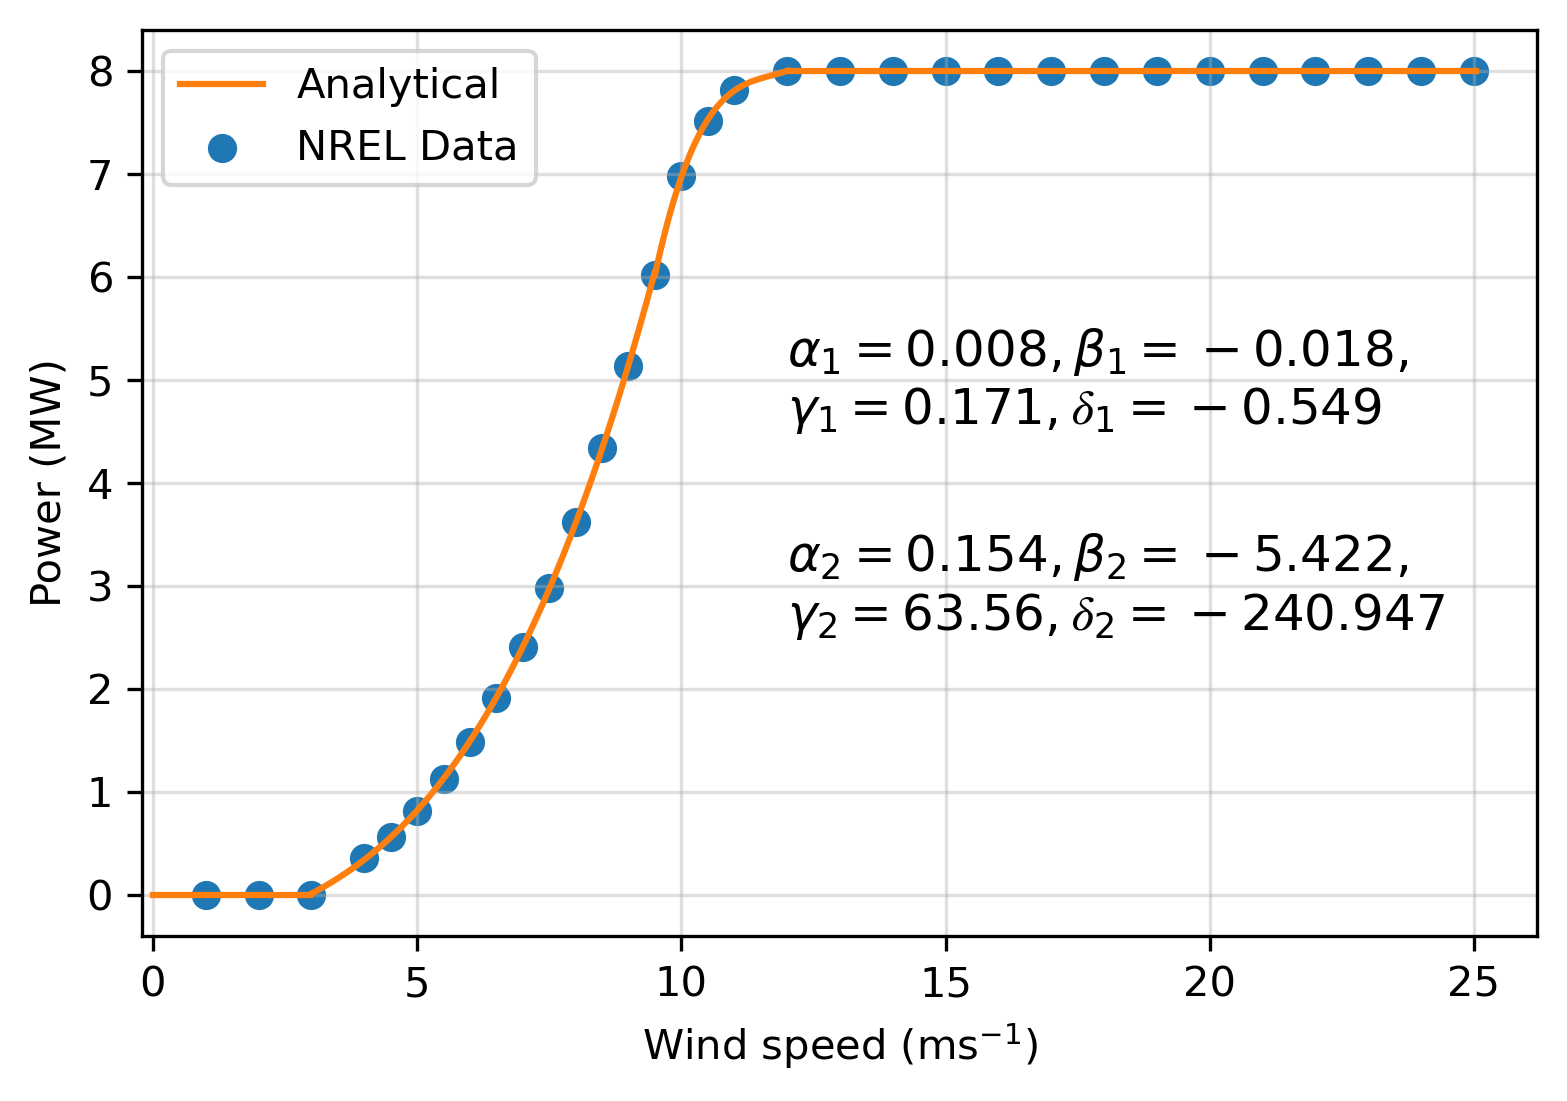

In [6]:
x_low = np.linspace(v_min,v_split,num=50)
x_high = np.linspace(v_split,v_rated,num=50)
v_low = np.polyval(fit_low,x_low)
v_high = np.polyval(fit_high,x_high)
x_stack = np.hstack((x_low,x_high))
v_stack = np.hstack((v_low,v_high))

plt.figure(dpi =300)
plt.scatter(power_curve[:,0],power_curve[:,1]/1000, label='NREL Data')

plt.plot(x_stack, v_stack,color='tab:orange', linestyle = '-', label='Analytical')
plt.axhline(y=8,color='tab:orange', linestyle = '-', xmin=11.6*0.1/2.5,xmax = 23.9 *0.1/2.5)
plt.axhline(y=0,color='tab:orange', linestyle = '-', xmin=0.008,xmax = v_min*0.1/2.5)
plt.xlabel(r'Wind speed (ms$^{-1}$)')
plt.ylabel('Power (MW)')

plt.text(12,4.57,f'$α_1 = {fit_low_text[0]}, β_1  = {fit_low_text[1]}$, \n$ γ_1 = {fit_low_text[2]}, 𝛿_1 = {fit_low_text[3]}$',size=12)
plt.text(12,2.57,f'$α_2 = {fit_high_text[0]}, β_2  = {fit_high_text[1]}$, \n$ γ_2 = {fit_high_text[2]}, 𝛿_2 = {fit_high_text[3]}$',size=12)
#plt.title('Power Curve')
plt.legend()
plt.grid(alpha=0.4)
plt.savefig('./figures/power_curve.pdf',bbox_inches='tight')

# Converting Wind Speed into Power

### Creating values for power

- wind_mag > 25 was previously set to 0, so can ignore

- where v < v_min is ignored as these values are set to 0 in the process anyway

- Use del for continuous 'clean-up' to save memory.

In [7]:
#where v >= v_rated, set to 8000
ds['p2'] = ds['wind_mag'] - ds['wind_mag'].where((ds['wind_mag']<v_rated),0)
ds['p2'] = ds['p2'].where((ds['p2']<v_rated),8000) 

ds['power'] = ds['p2']
del ds['p2']

#where v_min < v < v_split, apply low_func
ds['p3'] = ds['wind_mag'] - ds['wind_mag'].where((ds['wind_mag']<=v_min) | (ds['wind_mag']>=v_split),0) 
ds['p3'] = ds['p3'].where((ds['p3']<=v_min) | (ds['p3']>=v_split), np.polyval(fit_low,ds['p3'])) 

ds['power'] += ds['p3']*1000
del ds['p3']

#where v_split <= v < v_rated, apply high_func
ds['p4'] = ds['wind_mag'] - ds['wind_mag'].where((ds['wind_mag']<v_split) | (ds['wind_mag']>=v_rated),0) 
ds['p4'] = ds['p4'].where((ds['p4']<v_split) | (ds['p4']>=v_rated), np.polyval(fit_high,ds['p4']))

ds['power'] += ds['p4']*1000
del ds['p4']

ds.power.attrs["units"] = "kW"

KeyboardInterrupt: 

<xarray.DataArray 'power' (time: 8784, longitude: 1, latitude: 1)>
dask.array<getitem, shape=(8784, 1, 1), dtype=float32, chunksize=(8784, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 9.75
  * latitude   (latitude) float64 41.25
  * time       (time) datetime64[ns] 2010-01-01 ... 2011-01-01T23:00:00
Attributes:
    units:    kW


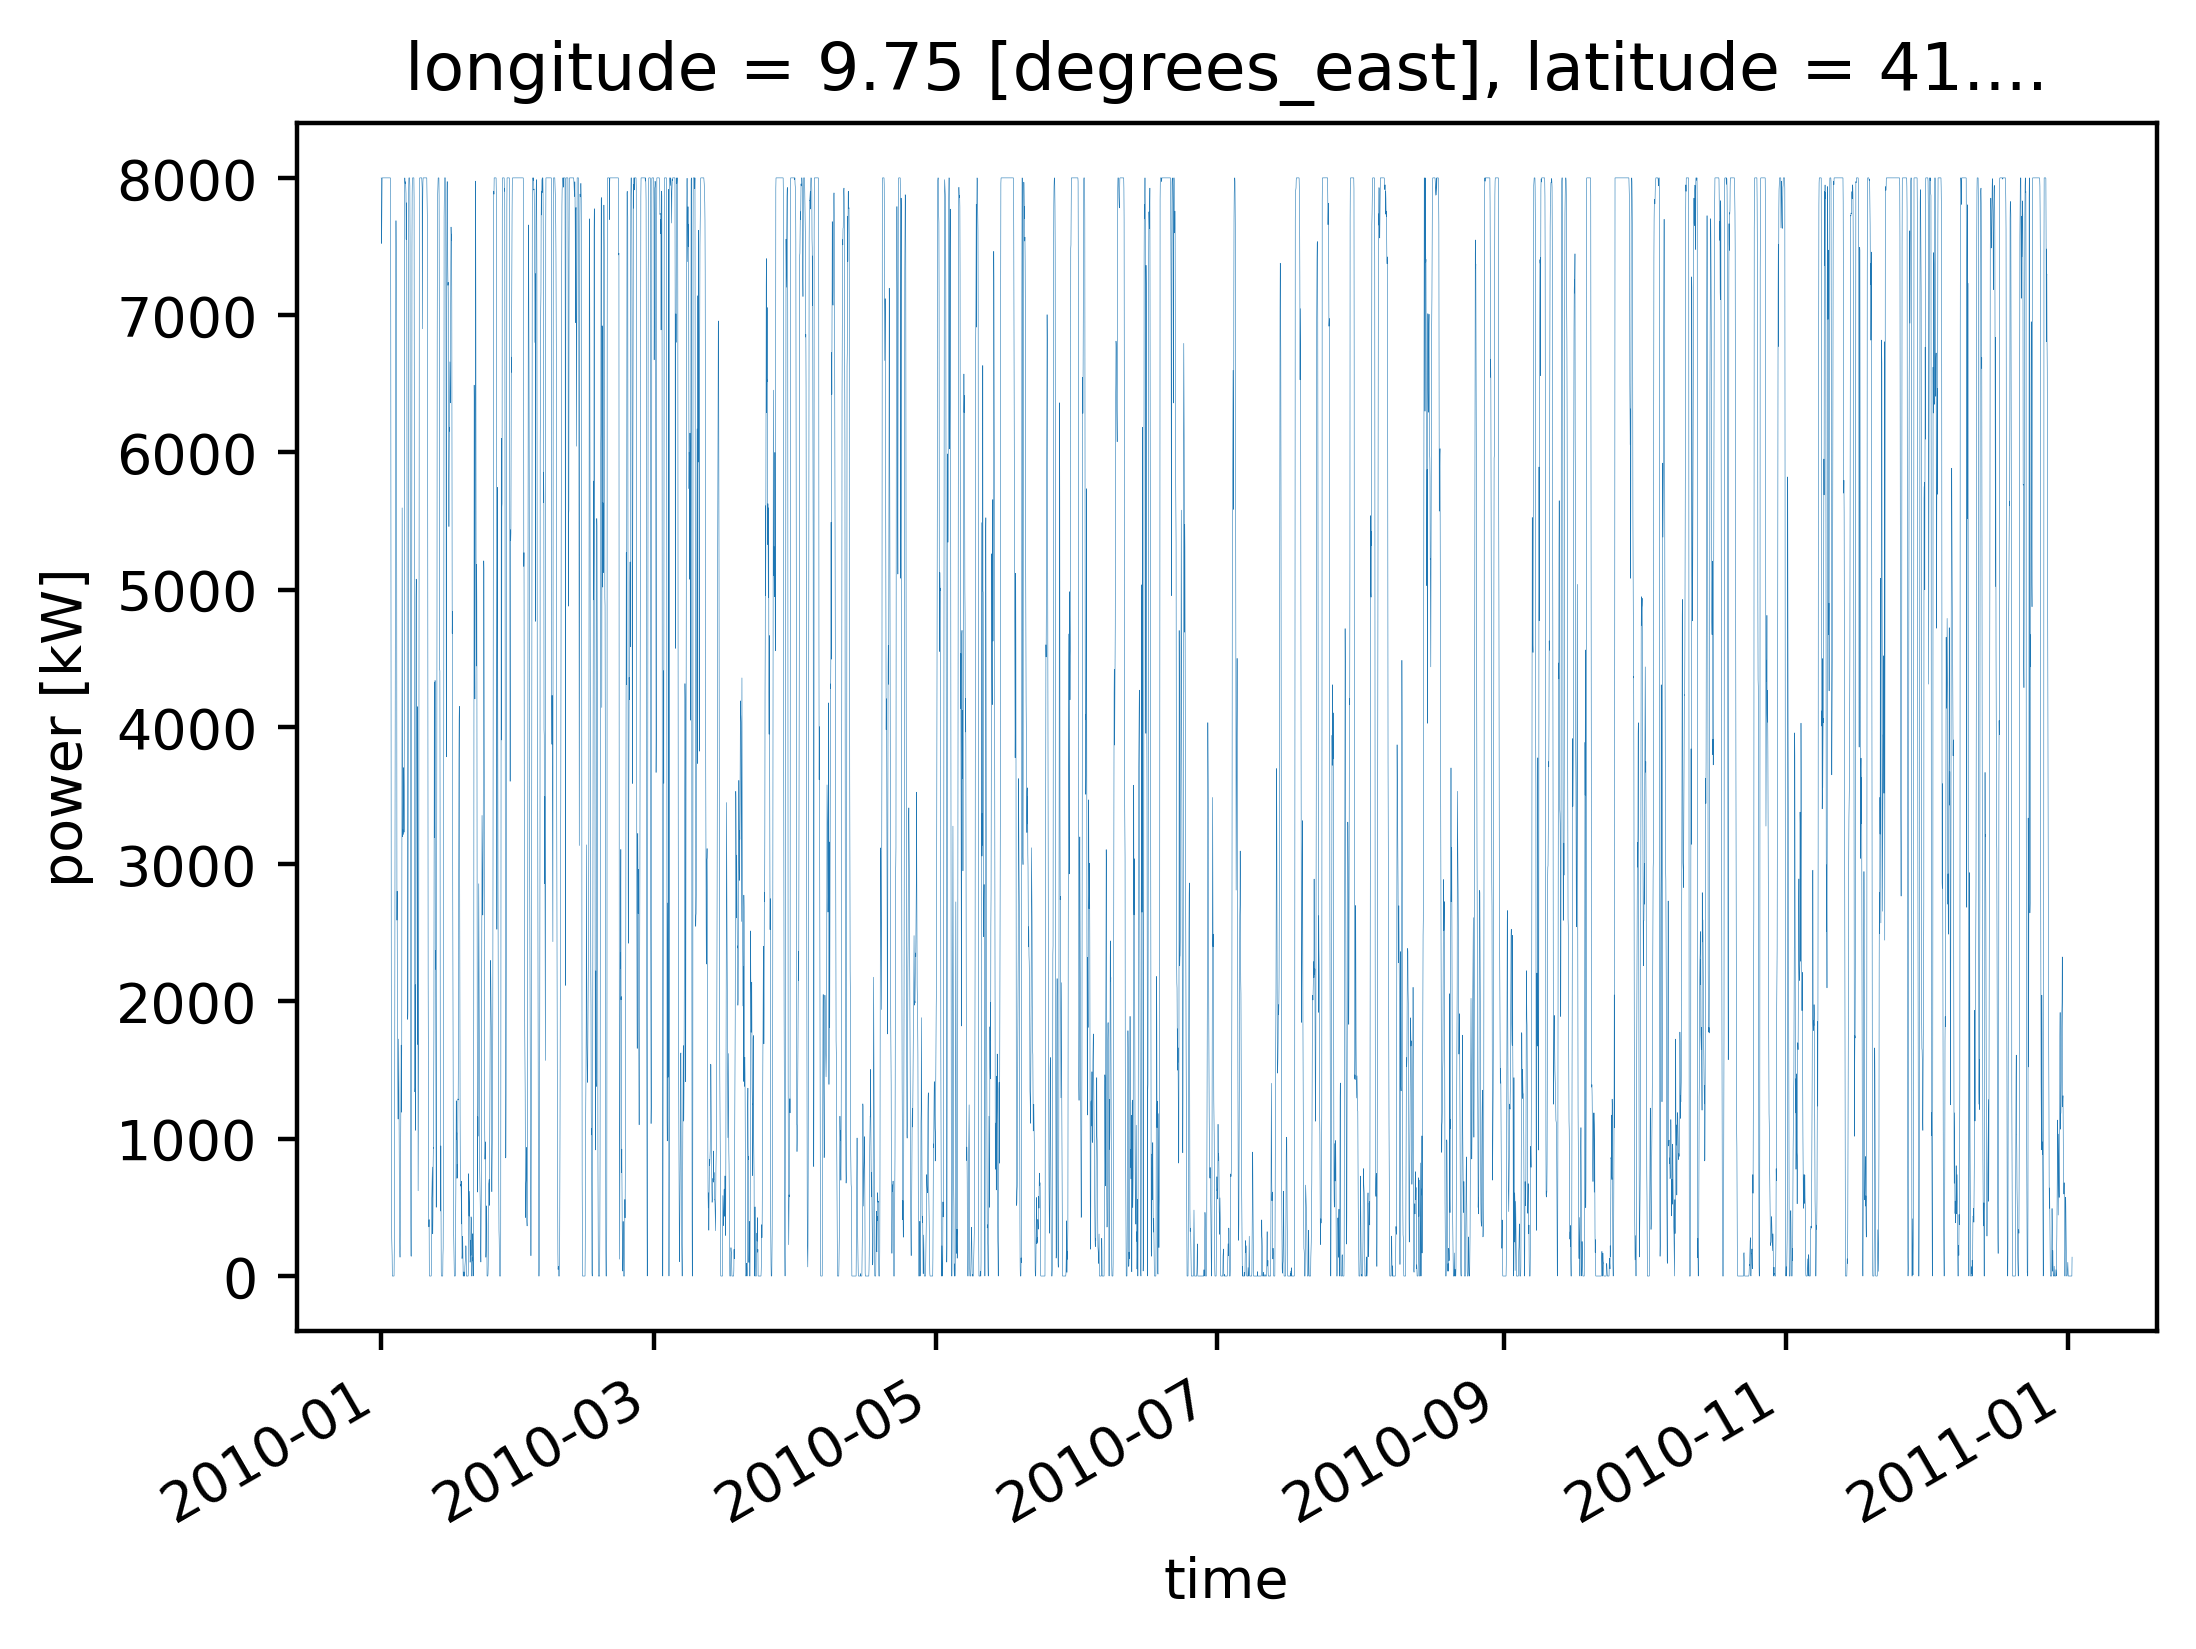

In [55]:
longitude = 9.75
latitude = 41.25

#plotting
plt.figure(dpi=400)
ds.sel(latitude=[latitude], longitude=[longitude],time=slice('2010-01-01', '2011-01-01'))['power'].plot(linewidth=0.1)
print(ds.sel(latitude=[latitude], longitude=[longitude],time=slice('2010-01-01', '2011-01-01'))['power'])

In [57]:
#opens and concatenates all datasets
#paths = ['./data/euro_locs/france_98-03.nc','./data/euro_locs/france_04-09.nc','./data/euro_locs/france_10-15.nc','./data/euro_locs/france_16-21.nc','./data/euro_locs/italy_98-03.nc','./data/euro_locs/italy_04-09.nc','./data/euro_locs/italy_10-15.nc','./data/euro_locs/italy_16-21.nc','./data/euro_locs/spain_98-03.nc','./data/euro_locs/spain_04-09.nc','./data/euro_locs/spain_10-15.nc','./data/euro_locs/spain_16-21.nc',]
#ds_euro = xr.open_mfdataset(paths, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': 200} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
#ds_euro = wind_eval(original_height,height,ds_euro,surface_roughness)

#open from feather file
paths_euro = ['./data/netcdf/euro_file.nc']
ds_euro = xr.open_mfdataset(paths_euro,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
paths_uk = ['./data/netcdf/80m_full_file.nc']
ds_uk = xr.open_mfdataset(paths_uk,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
ds = xr.merge([ds_euro,ds_uk])

/home/xzcaphbe/.conda/envs/env3.8/lib/python3.8/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home/xzcaphbe/.conda/envs/env3.8/lib/python3.8/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
 

In [58]:
#saving file
ds.to_netcdf(path="./data/netcdf/euro_full_file.nc")
#ds.to_netcdf(path="./data/netcdf/80m_full_file.nc")
#ds.to_netcdf(path="./data/netcdf/euro_file.nc")

## Creating European Wind Speed dataset

In [3]:
paths_euro = ["./data/netcdf/euro_full_file.nc"]
ds_euro = xr.open_mfdataset(paths_euro,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override').compute()

In [4]:
def open_wind_farm_csv(location):
    """Opens the wind farm csv and outputs a dictionary of locations."""
    columns = defaultdict(list) # each value in each column is appended to a list
    with open(location) as f:
        reader = csv.DictReader(f) # read rows into a dictionary format
        for row in reader: # read a row as {column1: value1, column2: value2,...}
            for (k,v) in row.items(): # go over each column name and value 
                columns[k].append(v) # append the value into the appropriate list
                                     # based on column name k
    coords = dict()
    coords['Latitude'] = np.array(list(map(float, columns['Latitude'][:19])))
    coords['Longitude'] = np.array(list(map(float, columns['Longitude'][:19])))
    return coords

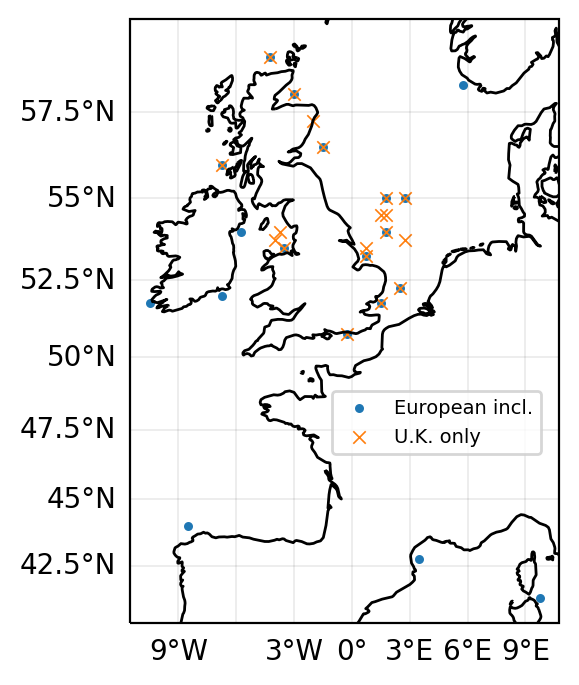

In [5]:
spec_farm_lats_eur = open_wind_farm_csv('./data/Wind_Farm_Locations_europe1.csv')["Latitude"]
spec_farm_lons_eur = open_wind_farm_csv('./data/Wind_Farm_Locations_europe1.csv')["Longitude"]
spec_farm_lats_eur = (np.round(spec_farm_lats_eur*4, decimals=0)/4)
spec_farm_lons_eur = (np.round(spec_farm_lons_eur*4, decimals=0)/4)

spec_farm_lats = open_wind_farm_csv('./data/Wind_Farm_Locations.csv')["Latitude"]
spec_farm_lons = open_wind_farm_csv('./data/Wind_Farm_Locations.csv')["Longitude"]
spec_farm_lats = (np.round(spec_farm_lats*4, decimals=0)/4)
spec_farm_lons = (np.round(spec_farm_lons*4, decimals=0)/4)

#index 0 includes european locations
#index 1 includes only UK locations
coords = np.zeros((2,19,2))
coords[0,:,:] = np.vstack((spec_farm_lats_eur,spec_farm_lons_eur)).transpose()
coords[1,:,:] = np.vstack((spec_farm_lats,spec_farm_lons)).transpose()


edge =-0.05
#plotting
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator()), dpi=200)
ax = plt.axes(projection=ccrs.Mercator())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.1, color='black', alpha=0.5 )
gl.top_labels = False
gl.right_labels = False
plt.title('Average Wind Speed')
plt.title('')

ax.set_extent([np.min(spec_farm_lons_eur)-1, np.max(spec_farm_lons_eur)+1,np.min(spec_farm_lats_eur)-1, np.max(spec_farm_lats_eur)+1], ccrs.PlateCarree())
ax.coastlines(resolution='50m')
img_extent = ([np.min(spec_farm_lons_eur)-1, np.max(spec_farm_lons_eur)+1,np.min(spec_farm_lats_eur)-1, np.max(spec_farm_lats_eur)+1])
#z = ax.imshow(euro_mean, origin='lower', extent=img_extent, transform = ccrs.PlateCarree())
#.scatter(ds_euro.coords['longitude'],ds_euro.coords['latitude'],weights = euro_mean,origin='lower', extent=img_extent, transform = ccrs.PlateCarree())
z = ax.scatter(x=spec_farm_lons_eur, y=spec_farm_lats_eur,marker='.', s=20,transform=ccrs.PlateCarree(),linewidth=1,label='European incl.') 
y = ax.scatter(x=spec_farm_lons, y=spec_farm_lats,marker='x', s=20,transform=ccrs.PlateCarree(),linewidth=0.6,label='U.K. only') 

plt.legend(fontsize=7, loc=(0.47,0.28))
divider = make_axes_locatable(ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig('./figures/avg_wind_speed_map.pdf',bbox_inches='tight')

## Opening European and All Data Points

In [6]:
def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True)) * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc,
        x,
        y,
        input_core_dims=[[dim], [dim]],
        dask="parallelized",
        output_dtypes=[float])

In [7]:
original_height = 100 #metres
height = 112 #metres
surface_roughness = 0.0005

#paths = ['./data/euro_locs/france_98-03.nc','./data/euro_locs/france_04-09.nc','./data/euro_locs/france_10-15.nc','./data/euro_locs/france_16-21.nc','./data/euro_locs/italy_98-03.nc','./data/euro_locs/italy_04-09.nc','./data/euro_locs/italy_10-15.nc','./data/euro_locs/italy_16-21.nc','./data/euro_locs/spain_98-03.nc','./data/euro_locs/spain_04-09.nc','./data/euro_locs/spain_10-15.nc','./data/euro_locs/spain_16-21.nc','./data/netcdf/100m1998-03.nc','./data/netcdf/100m2004-09.nc','./data/netcdf/100m2010-15.nc','./data/netcdf/100m2016-21.nc']
#ds_all = xr.open_mfdataset(paths, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': 200} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
#ds_all = wind_eval(original_height,height,ds_all,surface_roughness) #evaluates wind power magnitude for all points

In [8]:
combinations = 171 #combinations for 19 wind farms
ranks = xr.DataArray(np.zeros((coords.shape[0],combinations)))
distances = np.zeros((coords.shape[0],combinations))

#cycle through wind farm groups
for i in range(coords.shape[0]):
    count = 0
    start = time.time()
    #cycle through wind farms
    for j in range(coords.shape[1]):
        for k in range(j):
            array1 = ds_euro['power'].sel(latitude = coords[i,j,0], longitude = coords[i,j,1]).chunk(dict(time=-1))
            array2 = ds_euro['power'].sel(latitude = coords[i,k,0], longitude = coords[i,k,1]).chunk(dict(time=-1))
            val = spearman_correlation(array1, array2, 'time')
            ranks[i,count] = val
            loc1=(coords[i,j,0],coords[i,j,1])
            loc2=(coords[i,k,0],coords[i,k,1])
            distances[i,count] = hs.haversine(loc1,loc2) 
            count += 1
            del array1
            del array2
    end = time.time()
    print(i,', Time taken:',np.round(end-start,decimals=3),'s')
    #print(np.round(end-start,decimals=3))
    #print(np.round(end-start,decimals=3))
    
ranks = ranks.to_numpy()

0 , Time taken: 12.421 s
1 , Time taken: 10.994 s


European Rank avg: 0.313619903509033
UK Rank avg: 0.5626352235678365


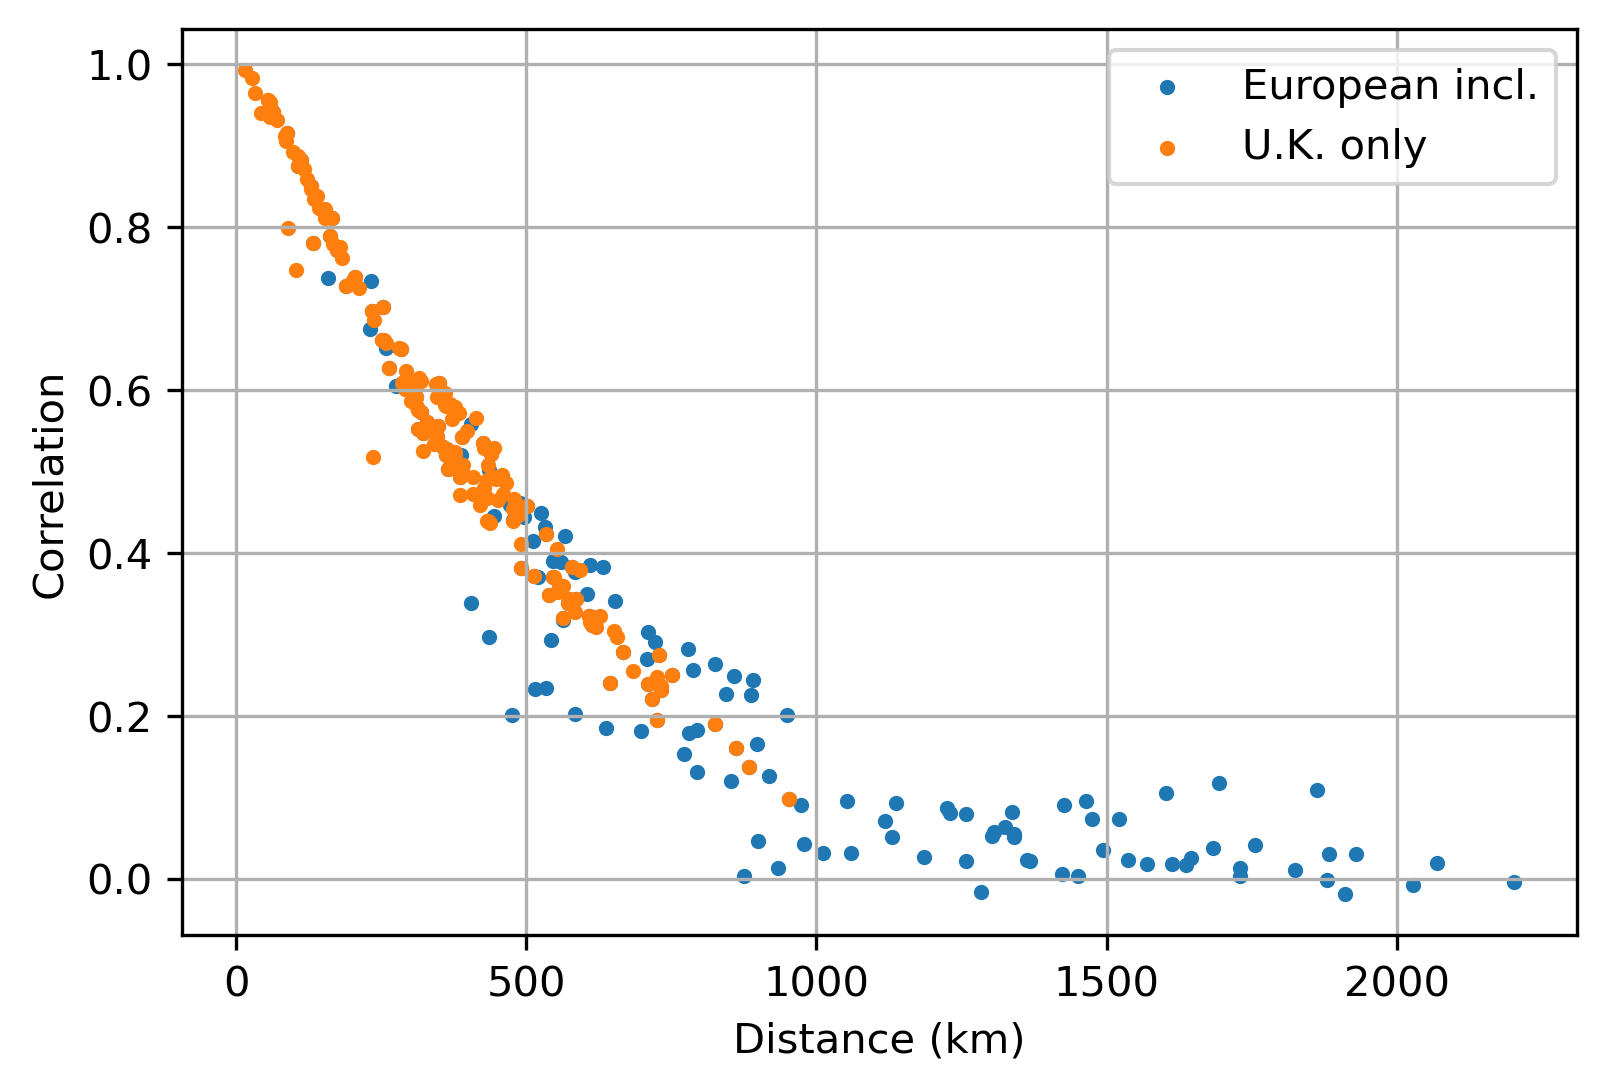

In [9]:
print('European Rank avg:',(np.average(ranks[0,:])))
print('UK Rank avg:',(np.average(ranks[1,:])))
labels = ['European incl.','U.K. only']

plt.figure(dpi=300)
for i in range(coords.shape[0]):
    plt.scatter(distances[i,:],ranks[i,:], label=labels[i],linewidth=0.5,s=10)
plt.legend()
plt.grid()
#plt.title('Correlation over distance')
plt.xlabel('Distance (km)')
plt.ylabel('Correlation')


plt.savefig('./figures/european_correlation.pdf',bbox_inches='tight')

## Exponential Model

European Rank avg: 0.313619903509033
UK Rank avg: 0.5626352235678365


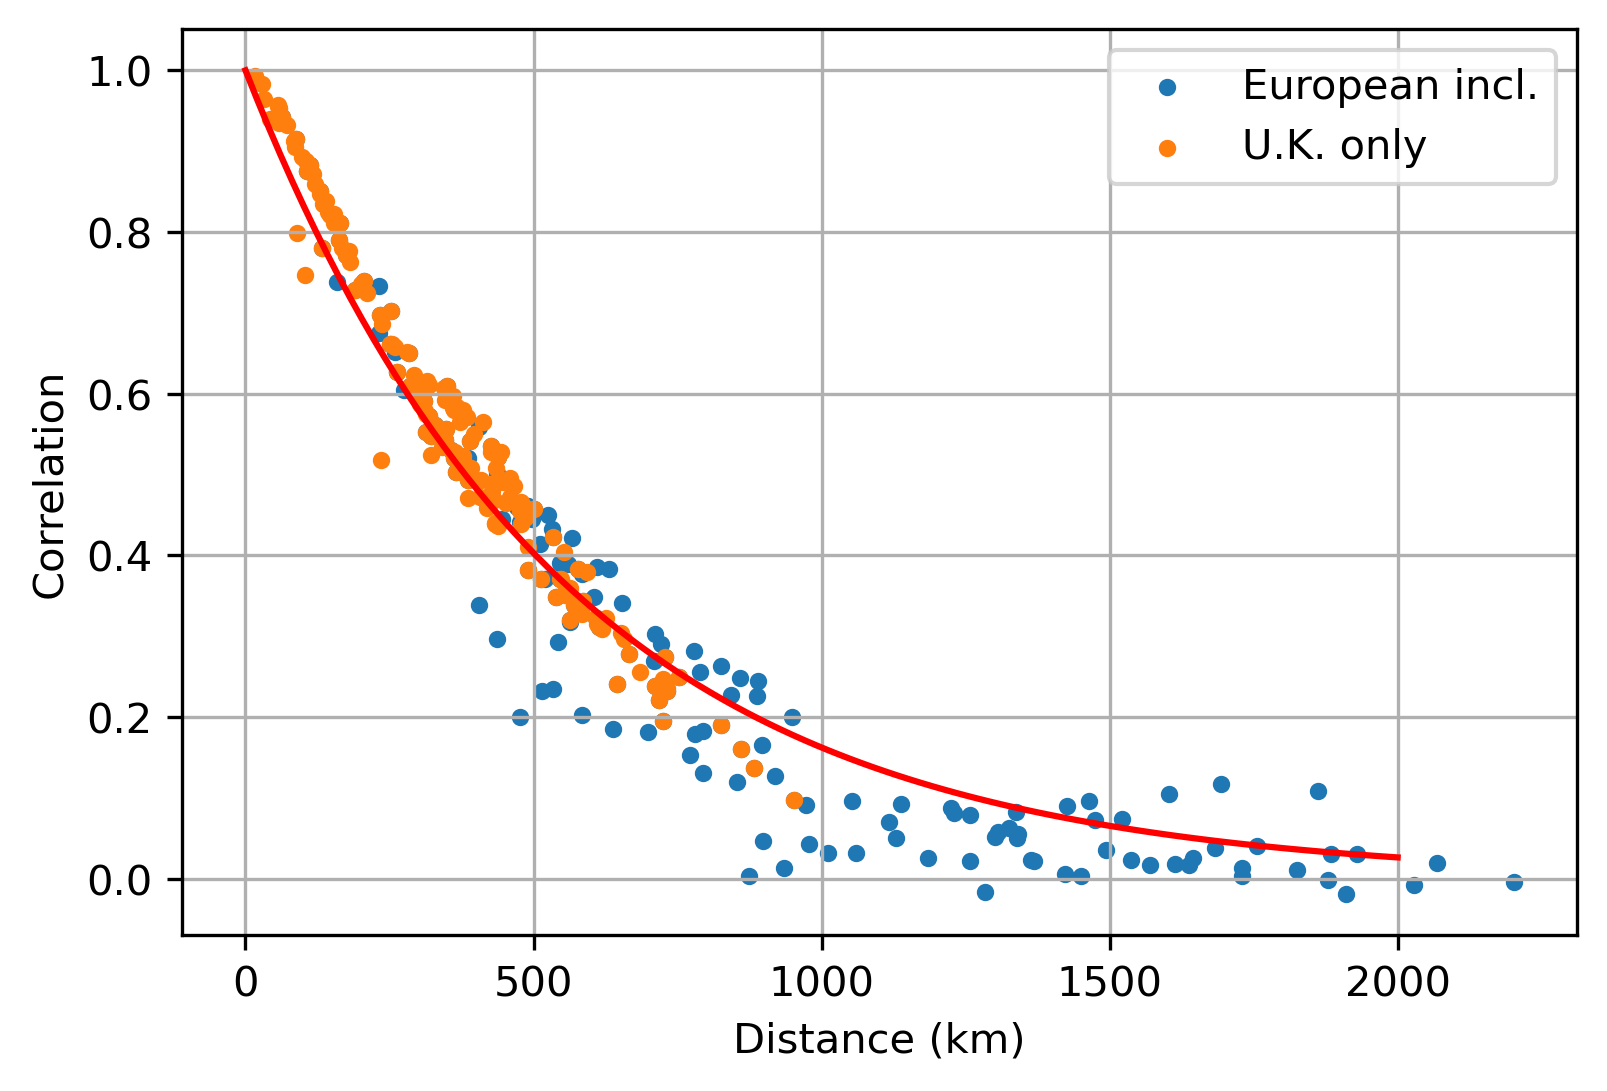

In [10]:
x = np.linspace(0,2000,num=100)
y = np.exp(-x/550)
print('European Rank avg:',(np.average(ranks[0,:])))
print('UK Rank avg:',(np.average(ranks[1,:])))
labels = ['European incl.','U.K. only']

plt.figure(dpi=300)
for i in range(coords.shape[0]):
    plt.scatter(distances[i,:],ranks[i,:], label=labels[i],s=10)
plt.plot(x,y,color='r')
plt.legend()
plt.grid()
#plt.title('Correlation over distance')
plt.xlabel('Distance (km)')
plt.ylabel('Correlation')


plt.savefig('./figures/european_correlation_curve_fitted.pdf',bbox_inches='tight')